#### <center>Intermediate Python and Software Enginnering</center>


## <center>Section 08 - Numba and Cython - Exercises</center>


### <center>Innovation Scholars Programme</center>
### <center>King's College London, Medical Research Council and UKRI <center>

In [1]:
import numpy as np


def qsort(arr):
    if len(arr) < 2:
        return arr
    else:
        pivot = arr[:1]
        rest = arr[1:]
        left = qsort(rest[rest <= pivot])
        right = qsort(rest[rest > pivot])

        return np.concatenate((left, pivot, right))


sortarr = qsort(np.random.rand(24))
print(sortarr)

[4.10204347e-04 4.12336712e-02 4.88113676e-02 8.68389056e-02
 9.08609522e-02 1.03223689e-01 3.19161582e-01 3.25400376e-01
 3.44399660e-01 3.66687784e-01 4.27310750e-01 4.31440715e-01
 4.90459715e-01 5.18068900e-01 6.40914560e-01 6.88939554e-01
 7.58214159e-01 8.10213738e-01 8.28274239e-01 8.35823595e-01
 8.48378188e-01 9.10604820e-01 9.14388321e-01 9.39519061e-01]


This takes some time for large arrays:

In [26]:
%timeit qsort(np.random.rand(100000).astype(np.float32))

309 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>

We can use Numba to speed things up when the arguments and operations are all known types like Numpy arrays:

In [27]:
from numba import jit


@jit(nopython=True)
def qsort_numba(arr):
    if len(arr) < 2:
        return arr
    else:
        pivot = arr[:1]
        rest = arr[1:]
        left = qsort_numba(rest[rest <= pivot])
        right = qsort_numba(rest[rest > pivot])

        return np.concatenate((left, pivot, right))


sortarr = qsort_numba(np.random.rand(24).astype(np.float32))
print(sortarr)

[0.02396028 0.04952728 0.05324014 0.1281545  0.1665196  0.25365162
 0.31407169 0.39164418 0.40723586 0.53781796 0.54020095 0.5461197
 0.5492994  0.5774176  0.5867986  0.6392583  0.64713866 0.6636575
 0.71143436 0.7976082  0.8279182  0.8528388  0.9215102  0.9329512 ]


<IPython.core.display.Javascript object>

In [28]:
%timeit qsort_numba(np.random.rand(100000).astype(np.float32))

42 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

### Exercise 1: 
Implement an array re-ordering function:

In [29]:
@jit(nopython=True)
def reorder_array(arr, indices, out):
    """
    Define a function which fills in `out` with values from `arr` such that a value
    at position `i` is taken from `arr[indices[i]]`. Implement this in pure Python,
    see how slow it is, then use Numba to speed it up.
    """


arr = np.random.rand(100000).astype(np.float32)
indices = np.arange(arr.shape[0])
out = np.zeros_like(arr)
np.random.shuffle(indices)

%timeit reorder_array(arr,indices,out)

422 ns ± 0.0924 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<IPython.core.display.Javascript object>

### Exercise 2: 
Use Numba's in-built parallel abilities to speed up the function even more.

Reference: https://numba.pydata.org/numba-doc/dev/user/parallel.html#explicit-parallel-loops

You will want to use prange and parallel=True option for jit, nogil=True may be a good idea also

In [ ]:
@jit(parallel=True, nogil=True)
def reorder_array_parallel(arr, indices, out):
    """
    Define a function which returns a new array of the same shape/type as `arr` with the
    value at position `i` is taken from `arr[indices[i]]`. Implement this in pure Python,
    see how slow it is, then use Numba to speed it up.
    """


arr = np.random.rand(100000).astype(np.float32)
indices = np.arange(arr.shape[0])
out = np.zeros_like(arr)

np.random.shuffle(indices)

%timeit reorder_array_parallel(arr,indices,out)

### Exercise 3: 
Below is the code to draw a Mandelbrot fractal. This is a popular example of iterating over arrays. The code is terribly slow, speed it up by compiling both functions with Numba. Can parallelism be applied here?

3.07 s ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


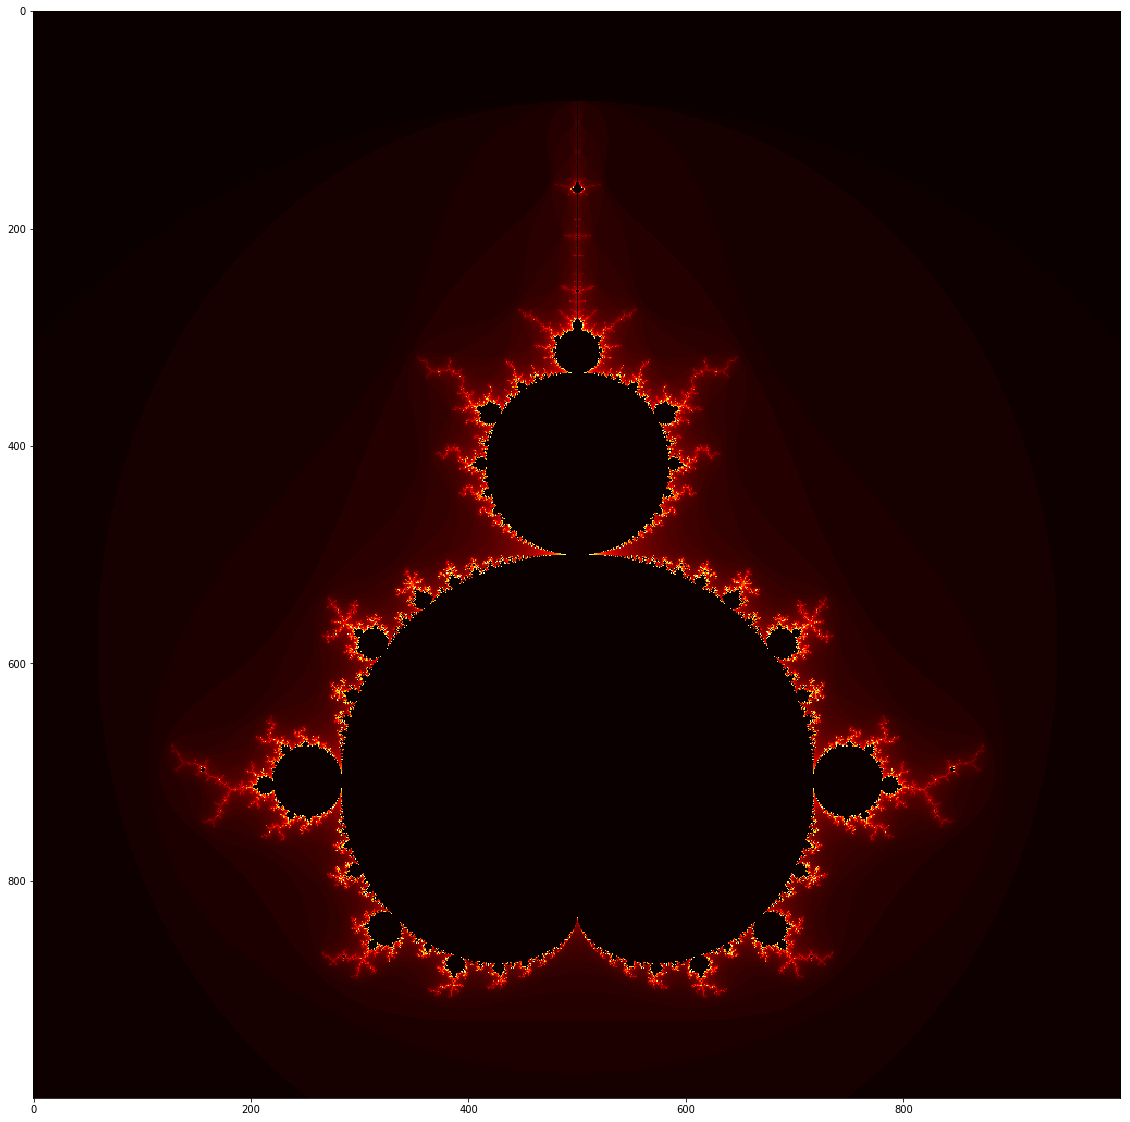

<IPython.core.display.Javascript object>

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


def mandelbrot(creal, cimag, max_iters):
    real = creal
    imag = cimag

    for n in range(max_iters):
        real2 = real * real
        imag2 = imag * imag

        if real2 + imag2 > 4.0:
            return n

        imag = 2 * real * imag + cimag
        real = real2 - imag2 + creal

    return 0


def calc_mandelbrot(im, max_iters, centerx, centery, valuewidth, valueheight):
    w = im.shape[0]
    h = im.shape[1]

    for i in range(w):
        for j in range(h):
            creal = (i / w - 0.5) * valuewidth + centerx
            cimag = (j / h - 0.5) * valueheight + centery

            im[i, j] = mandelbrot(creal, cimag, max_iters)


max_iters = 100
im = np.zeros((1000, 1000))

%timeit calc_mandelbrot(im,max_iters,-0.75,0,3,3)

plt.figure(figsize=(20, 20))
plt.imshow(im * (im < max_iters), cmap="hot")

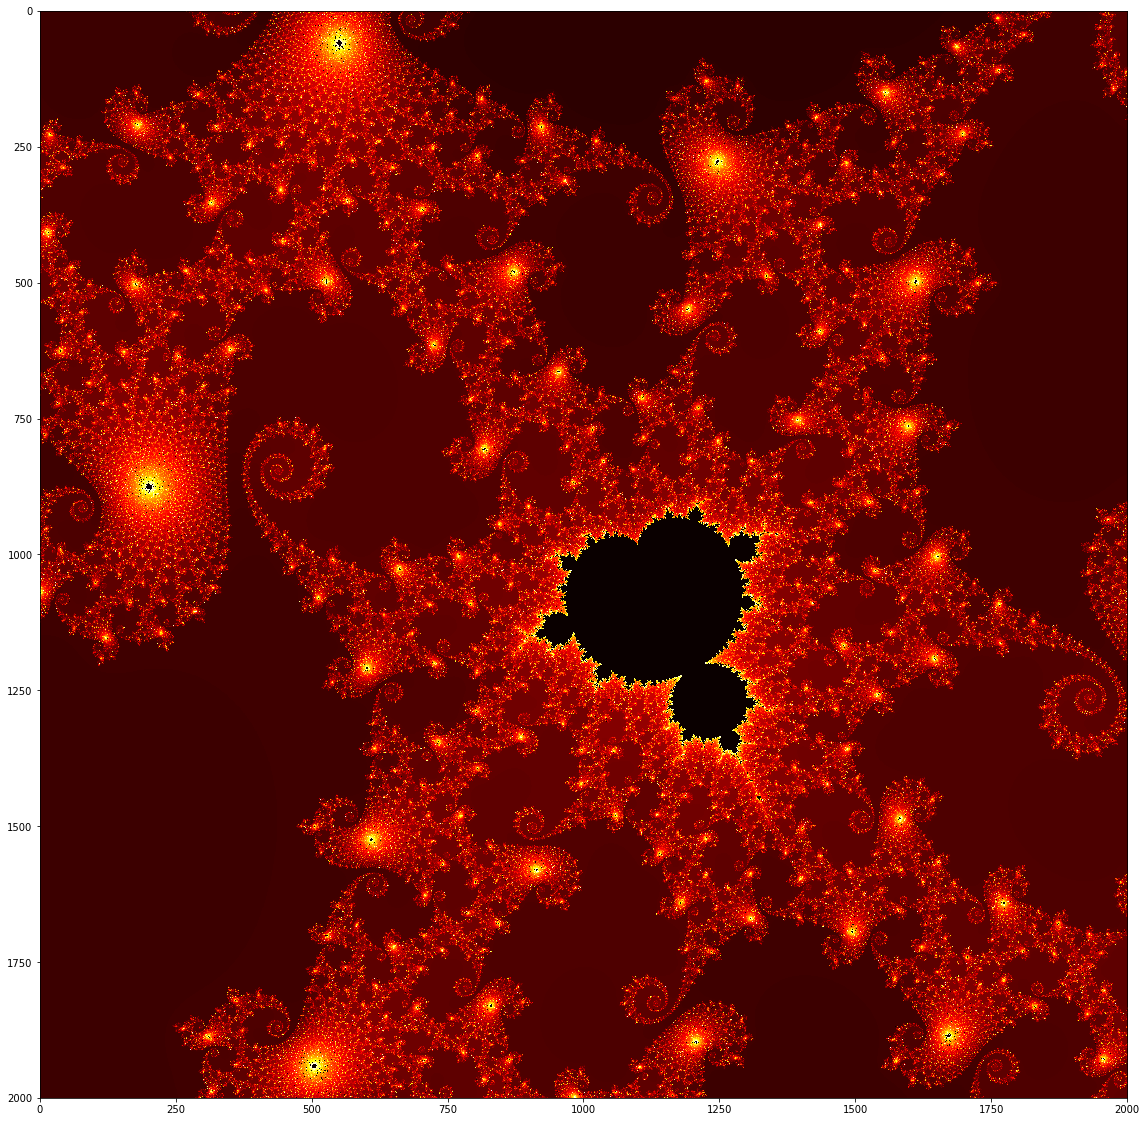

<IPython.core.display.Javascript object>

In [32]:
max_iters = 2000
im = np.zeros((2000, 2000))

calc_mandelbrot(im, max_iters, -0.74875, 0.06507, 0.0001, 0.0001)

plt.figure(figsize=(20, 20))
plt.imshow(im * (im < max_iters), cmap="hot")

## Cython

We need to load the extension for Cython in the notebook:

In [33]:
%load_ext cython

<IPython.core.display.Javascript object>

### Exercise 4:
Implement the reordering in Cython:

In [34]:
%%cython

cpdef void reorder_array_cython(float[:] arr,int[:] indices,float[:] out):
    """
    Define a function which fills in `out` with values from `arr` such that a value
    at position `i` is taken from `arr[indices[i]]`. Implement this in pure Python,
    see how slow it is, then use Numba to speed it up.
    """

<IPython.core.display.Javascript object>

In [35]:
arr = np.random.rand(100000).astype(np.float32)
indices = np.arange(arr.shape[0]).astype(np.int32)
out = np.zeros_like(arr)
np.random.shuffle(indices)

%timeit reorder_array_cython(arr,indices,out)

1.14 µs ± 0.577 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<IPython.core.display.Javascript object>

### Exercise 5: 

We can get more performance by using Cython parallel features. Re-implement the reorder function using Cython's prange. Compare speeds versus the above.

There are also decorators that may help: https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#tuning-indexing-further

In [36]:
%%cython 

import cython
from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef void reorder_array_cython_parallel(float[:] arr,int[:] indices,float[:] out) nogil:
    """
    Define a function which fills in `out` with values from `arr` such that a value
    at position `i` is taken from `arr[indices[i]]`. Implement this in pure Python,
    see how slow it is, then use Numba to speed it up.
    """

<IPython.core.display.Javascript object>

In [37]:
arr = np.random.rand(100000).astype(np.float32)
indices = np.arange(arr.shape[0]).astype(np.int32)
out = np.zeros_like(arr)
np.random.shuffle(indices)

%timeit reorder_array_cython_parallel(arr,indices,out)

1.12 µs ± 1.05 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<IPython.core.display.Javascript object>

### Exercise 6: 

Re-implement the Mandelbrot program with Cython. I have provided the function prototypes again, you should be using `cdef` to declare variables and `prange` where appropriate.

In [38]:
%%cython 

import cython
from cython.parallel import prange

cdef int mandelbrot_cython(double creal, double cimag, int max_iter) nogil:
    """Calculate the iteration count for the complex value (creal,cimag)."""

cpdef void calc_mandelbrot_cython(double[:,:] im,int max_iters,double centerx,double centery,double valuewidth,double valueheight) nogil:
    """Calculate a return a Mandelbrot matrix."""

<IPython.core.display.Javascript object>

467 ns ± 16.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


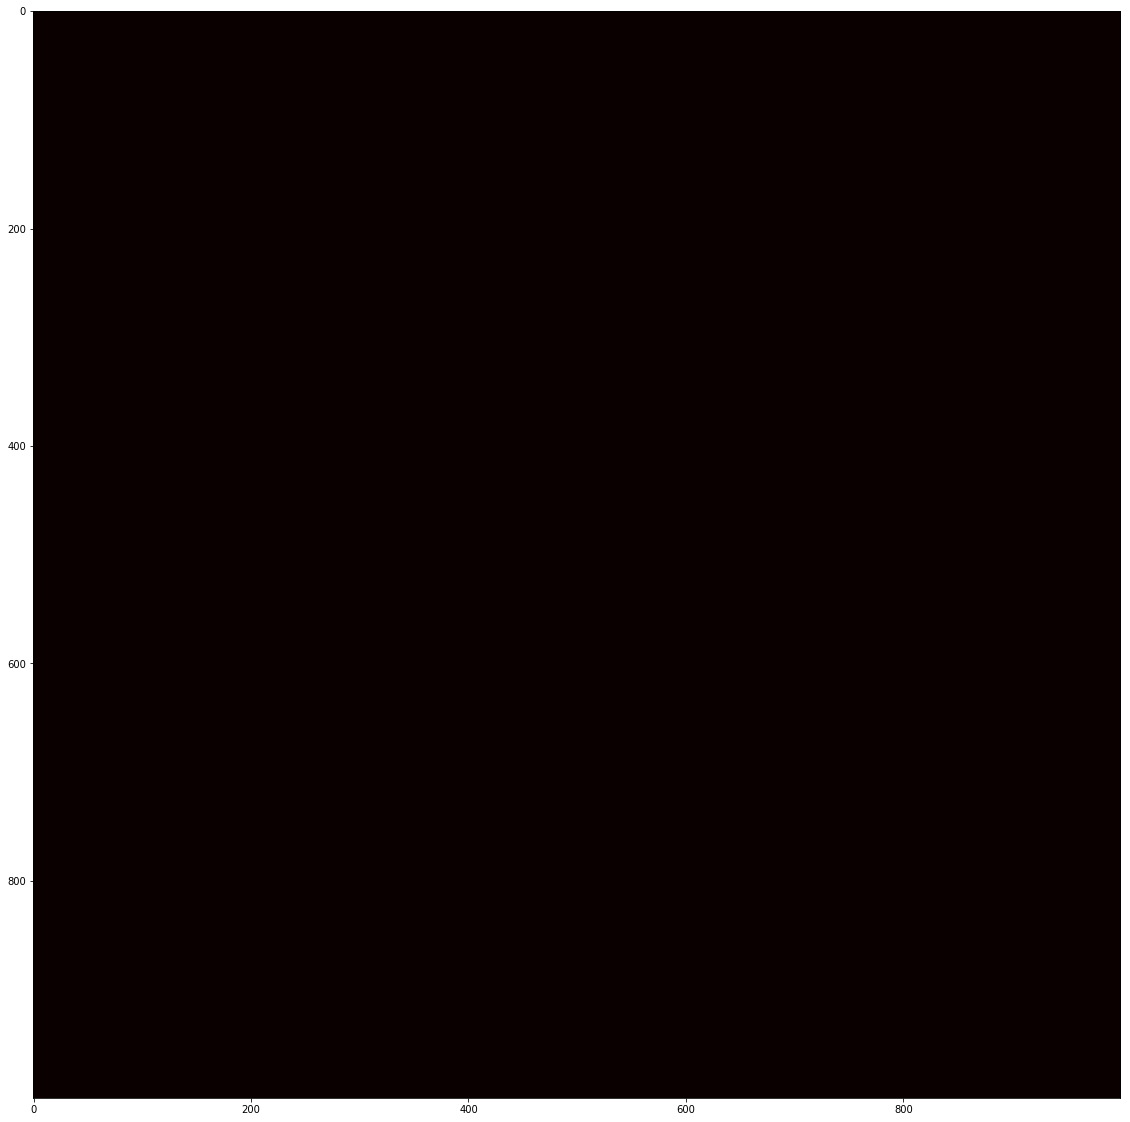

<IPython.core.display.Javascript object>

In [39]:
max_iters = 100
im = np.zeros((1000, 1000))

%timeit calc_mandelbrot_cython(im,max_iters,-0.75,0,3,3)

plt.figure(figsize=(20, 20))
plt.imshow(im * (im < max_iters), cmap="hot")

## Bonus: 

Mandelbrot implemented using `numba.vectorize`. There's nothing to do here, it's just an interesting implementation which is fastest of those above.

In [40]:
from numba import vectorize

# the arguments to vectorize state the input types and return types
# the target= argument states the execution model, "cpu", "parallel", or "cuda"
@vectorize(["float64(float64, float64, int32)"], target="parallel")
def mandelbrot_v(creal, cimag, max_iters):
    real = creal
    imag = cimag

    for n in range(max_iters):
        real2 = real * real
        imag2 = imag * imag

        if real2 + imag2 > 4.0:
            return n

        imag = 2 * real * imag + cimag
        real = real2 - imag2 + creal

    return 0


def mandelbrot_vectorize(minx, maxx, miny, maxy, width, height, max_iters):
    x, y = np.mgrid[minx : maxx : (maxx - minx) / width, miny : maxy : (maxy - miny) / height]

    return mandelbrot_v(x, y, max_iters)

<IPython.core.display.Javascript object>

In [ ]:
max_iters = 100

im = mandelbrot_vectorize(-2.0, 1, -1.5, 1.5, 1000, 1000, max_iters)

%timeit mandelbrot_vectorize(-2.,1,-1.5,1.5,1000,1000,max_iters)

plt.figure(figsize=(20, 20))
plt.imshow(im * (im < max_iters), cmap="afmhot")